In [174]:
library(zoo)
library(rugarch)
library(ggplot2)
library(reshape2)

In [4]:
intc <- read.zoo("../data/0933OS_Code/Chapter 1/intc.csv", sep=",", header=TRUE, format="%Y-%m", FUN= as.yearmon)

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


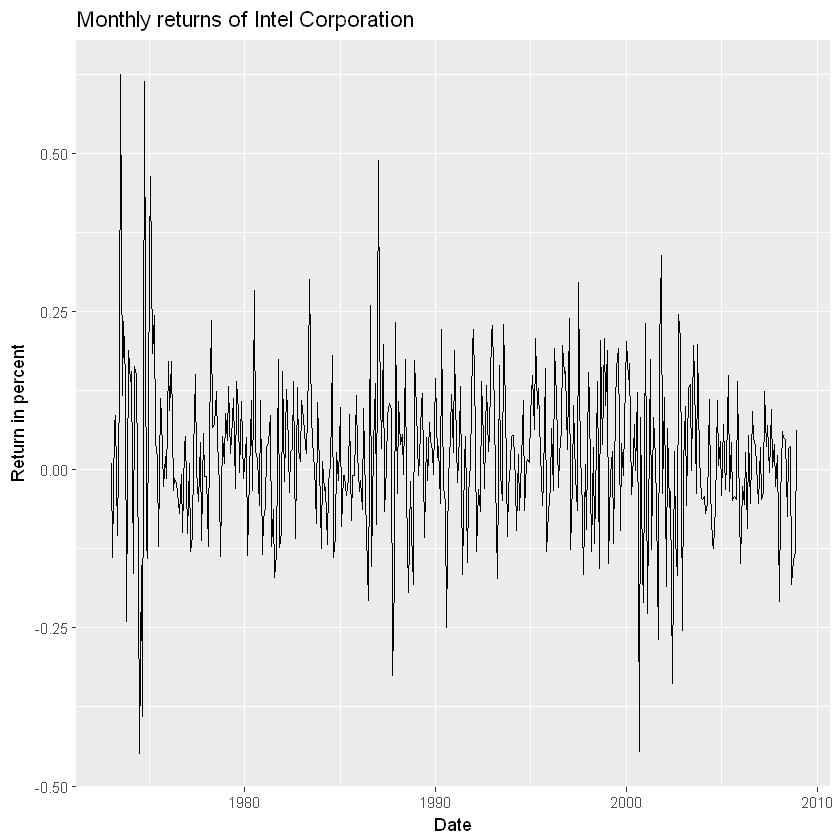

In [9]:
ggplot(data=fortify(intc, melt=TRUE)) +
    geom_line(aes(x=Index, y=Value)) +
    labs(x='Date', y='Return in percent', title='Monthly returns of Intel Corporation')

In [22]:
# 제곱 수익률에 대한 Ljung-Box 검정(lag=12)
Box.test(coredata(intc^2), type='Ljung-Box', lag=12)


	Box-Ljung test

data:  coredata(intc^2)
X-squared = 79.345, df = 12, p-value = 5.502e-12


In [56]:
(intc_garch11_spec <- ugarchspec(variance.model = list(garchOrder=c(1,1)), mean.model=list(armaOrder=c(0,0))))


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 


In [58]:
(intc_garch11_fit <- ugarchfit(spec=intc_garch11_spec, data=intc))


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.019092    0.005551   3.4394 0.000583
omega   0.001053    0.000462   2.2779 0.022730
alpha1  0.094367    0.031151   3.0293 0.002451
beta1   0.836508    0.047443  17.6319 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.019092    0.006417   2.9755 0.002925
omega   0.001053    0.000500   2.1040 0.035381
alpha1  0.094367    0.033946   2.7799 0.005437
beta1   0.836508    0.049150  17.0195 0.000000

LogLikelihood : 298.5009 

Information Criteria
------------------------------------
                    
Akaike       -1.3634
Bayes        -1.3258
Shibata      -1.3636
Hannan-Quinn -1.3486

Weig

In [62]:
intc_garch11_roll <- ugarchroll(intc_garch11_spec, intc,
    n.start=120, refit.every=1, refit.window='moving',
    solver='hybrid', calculate.VaR=TRUE, VaR.alpha=0.01, keep.coef=TRUE)

In [63]:
report(intc_garch11_roll, type='VaR', VaR.alpha=0.01, conf.level=0.99)

VaR Backtest Report
Model:				sGARCH-norm
Backtest Length:	312
Data:				

alpha:				1%
Expected Exceed:	3.1
Actual VaR Exceed:	5
Actual %:			1.6%

Unconditional Coverage (Kupiec)
Null-Hypothesis:	Correct Exceedances
LR.uc Statistic:	0.968
LR.uc Critical:		6.635
LR.uc p-value:		0.325
Reject Null:		NO

Conditional Coverage (Christoffersen)
Null-Hypothesis:	Correct Exceedances and
					Independence of Failures
LR.cc Statistic:	NaN
LR.cc Critical:		9.21
LR.cc p-value:		NaN
Reject Null:		NA


In [153]:
intc_VaR <- zoo(intc_garch11_roll@forecast$VaR[,1])
index(intc_VaR) <- yearmon(seq(1983,2009-1/12,by=1/12))
intc_actual <- zoo(intc_garch11_roll@forecast$VaR[,2])
index(intc_actual) <- index(intc_VaR)

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.
Don't know how to automatically pick scale for object of type zoo. Defaulting to continuous.


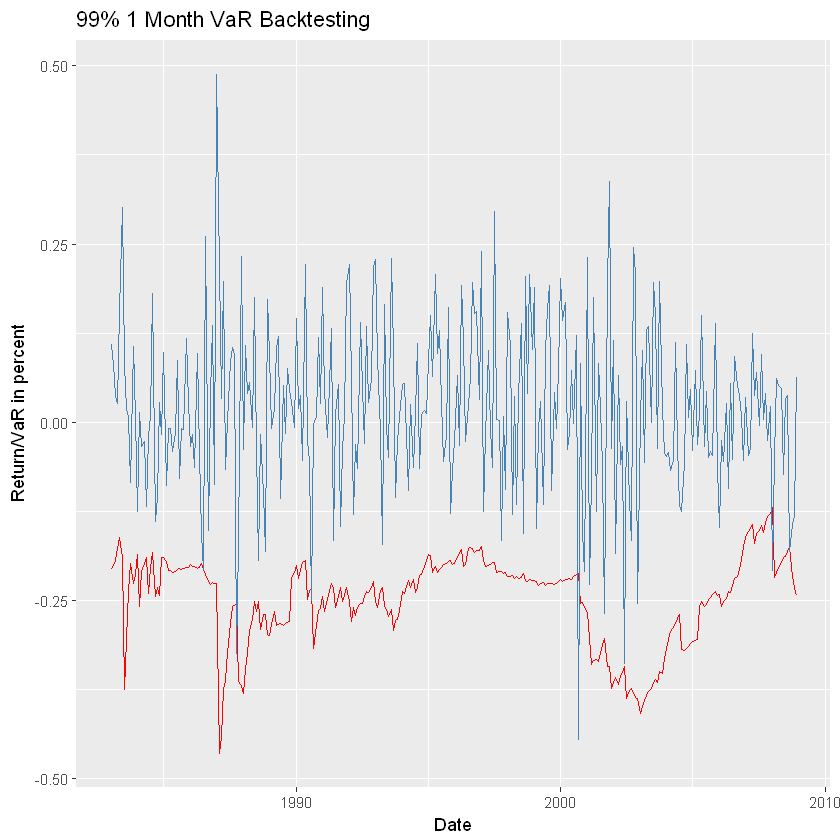

In [191]:
ggplot() +
    geom_line(aes(x=index(intc_VaR),y=intc_VaR), color='red') +
    geom_line(aes(x=index(intc_actual),y=intc_actual), color='steelblue') +
    labs(x='Date', y='Return/VaR in percent', title='99% 1 Month VaR Backtesting')

In [104]:
(intc_garch11_fcst <- ugarchforecast(intc_garch11_fit, n.ahead=12))


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 12
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=12 2008]:
      Series  Sigma
T+1  0.01909 0.1167
T+2  0.01909 0.1172
T+3  0.01909 0.1177
T+4  0.01909 0.1181
T+5  0.01909 0.1184
T+6  0.01909 0.1188
T+7  0.01909 0.1191
T+8  0.01909 0.1194
T+9  0.01909 0.1197
T+10 0.01909 0.1200
T+11 0.01909 0.1202
T+12 0.01909 0.1204

